This notebook shows example useage of the `traffic_anomaly` package. Meant for vehicle volumes or travel times, this package uses Ibis to write queries for any SQL backend. It efficiently decomposes multiple time series at once using robust median decomposition, then classify anomalies. Also, it handles missing data. To install the package:

```bash
pip install traffic_anomaly
```

In this example, the sample dataset are a series of vehicle travel times during September 2022 along different segments of Sunnyside Road in Happy Valley, Oregon. The location was chosen due to its cheerful name and because unusual delays were caused by paving projects during the analyzed time period.

First, lets decompose the time series data into trend, seasonal, and residual components using Median Decomposition to be robust against outliers.

# Median Time Series Decomposition

In [9]:
import src.traffic_anomaly
import matplotlib.pyplot as plt

# Let's load and inspect sample data that comes with the package!
from src.traffic_anomaly import sample_data

data = sample_data.data
print('Sample Data (travel times along Sunnyside Rd in Seconds)\n\n', data.head())
groups = sample_data.groups
print('\nSample Data Groups\n\n', groups)

Sample Data (travel times along Sunnyside Rd in Seconds)

           id           timestamp      value
0  448838574 2022-09-02 06:00:00  20.709999
1  448838574 2022-09-02 07:00:00  22.952499
2  448838574 2022-09-02 08:00:00  23.557501
3  448838574 2022-09-02 09:00:00  26.372499
4  448838574 2022-09-02 10:00:00  27.415001

Sample Data Groups

           id            group
0  448838574  SE SUNNYSIDE RD
1  448838575  SE SUNNYSIDE RD
2  448904537  SE SUNNYSIDE RD
3  448904538  SE SUNNYSIDE RD
4  448905974  SE SUNNYSIDE RD
5  448905975  SE SUNNYSIDE RD


The column names must match exactly for the package to work. In this sample data, `id` is the identifier for the different roadway segments. 

Let's decompose our sample data. This step does NOT use `group` column so don't joint that to the data just yet.

In [10]:
decomp = src.traffic_anomaly.median_decompose(
    data=data, # Pandas DataFrame or Ibis Table (for compatibility with any SQL backend)
    freq_minutes=60, # Frequency of the time series in minutes
    rolling_window_days=7, # Rolling window size in days. Should be a multiple of 7 for traffic data
    drop_days=7, # Should be at least 7 for traffic data
    min_rolling_window_samples=56, # Minimum number of samples in the rolling window, set to 0 to disable. 
    min_time_of_day_samples=7, # Minimum number of samples for each time of day (like 2:00pm), set to 0 to disable
    return_sql=False # Return SQL queries instead of Pandas DataFrames for running on SQL backends
)
decomp.head(3)

,timestamp,id,value,median,season_day,season_week,resid
0,2022-09-09 06:00:00,448838574,22.327499,24.223751,-4.209375,0.411877,1.901247
1,2022-09-09 06:00:00,448838575,19.357500,22.312500,-6.333125,0.946874,2.431252
2,2022-09-09 06:00:00,448904537,24.517500,30.972500,-6.562502,-0.217497,0.324999


Now that the travel times have been decomposed, look at a sample time period for just one roadway segment and plot it.

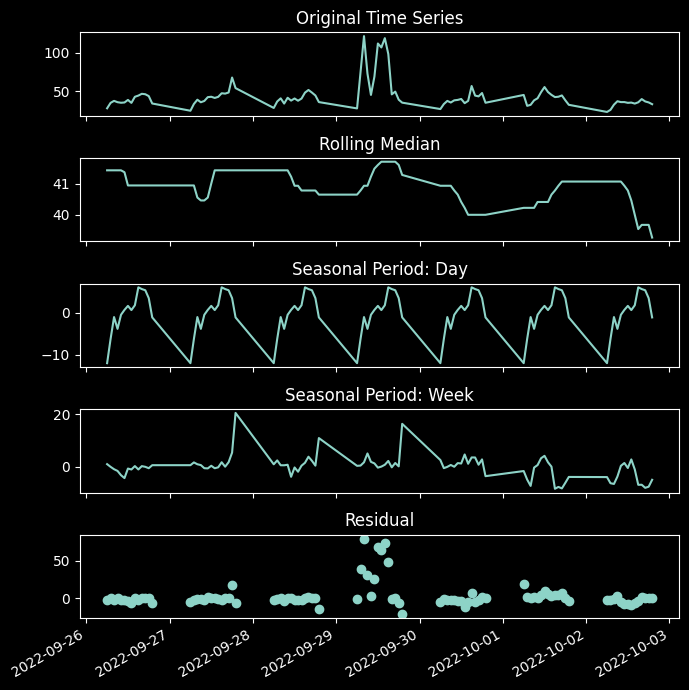

In [11]:
# Plot the decomposed time series
sample = decomp.set_index(['timestamp', 'id']).loc(axis=0)['2022-09-26':'2022-10-02',[448905975]]
x = sample.index.get_level_values(level=0)

plt.rcParams["figure.figsize"] = (7, 7)
fig, ax = plt.subplots(5)

ax[0].plot_date(x, sample['value'].values, '-')
ax[0].set_title('Original Time Series')

ax[1].plot_date(x, sample['median'].values, '-')
ax[1].set_title('Rolling Median')

ax[2].plot_date(x, sample['season_day'].values, '-')
ax[2].set_title('Seasonal Period: Day')

ax[3].plot_date(x, sample['season_week'].values, '-')
ax[3].set_title('Seasonal Period: Week')

ax[4].plot_date(x, sample['resid'].values)
ax[4].set_title('Residual')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

As you can see, there are anomalies on the 29th. Because the package uses medians instead of means, the anomalies do not show up in the seasonal components, just the residuals. This is by design, to make anomalies easier to detect.

# Anomaly Classification Example

(continued from above)

`traffic_anomaly` can classify two separate types of anomalies:

1. Entity-Level Anomalies are detected for individual entities based on their own historical patterns, without considering the group context.
2. Group-Level Anomalies are detected for entities when compared to the behavior of other entities within the same group. Group-level anomalies are more rare because in order to be considered for classification as a group-level anomaly, a time period must also have been classified as an entity-level anomaly.


Lets start with Entity-Level Anomalies.

In [16]:
# Apply anomaly detection
anomaly = src.traffic_anomaly.find_anomaly(
    decomp, # Decomposed time series as a Pandas DataFrame or Ibis Table
    threshold=3.5, # Z-score threshold for anomaly classification
    MAD=False # Option to use Median Absolute Deviation instead of Standard Deviation, default is False
)
anomaly.head(3)

,timestamp,id,value,median,season_day,season_week,resid,anomaly
0,2022-09-09 06:00:00,448838574,22.327499,24.223751,-4.209375,0.411877,1.901247,False
1,2022-09-09 06:00:00,448838575,19.357500,22.312500,-6.333125,0.946874,2.431252,False
2,2022-09-09 06:00:00,448904537,24.517500,30.972500,-6.562502,-0.217497,0.324999,False


Now, display the anomalies found as red dots overlaid onto the plot made in the previous step.

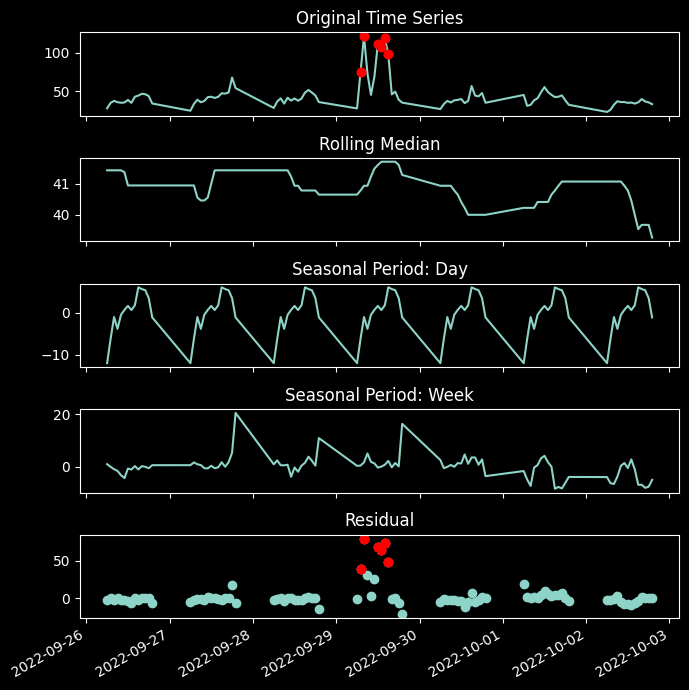

In [17]:
anomaly_sample = anomaly.set_index(['timestamp', 'id']).sort_index().loc(axis=0)['2022-09-26':'2022-10-02',[448905975]]
anomaly_sample = anomaly_sample[anomaly_sample['anomaly']]
anomaly_x = anomaly_sample.index.get_level_values(level=0)

ax[0].plot_date(anomaly_x, anomaly_sample['value'].values, color='red')
ax[4].plot_date(anomaly_x, anomaly_sample['resid'].values, color='red')
fig

### Group-Level Anomalies

To classify group-level anomalies, join the group column to the decomposed data and run the classification again.

In [18]:
# Join the groups to the data
with_group = decomp.merge(groups, on='id')
with_group.head(3)

,timestamp,id,value,median,season_day,season_week,resid,group
0,2022-09-09 06:00:00,448838574,22.327499,24.223751,-4.209375,0.411877,1.901247,SE SUNNYSIDE RD
1,2022-09-09 07:00:00,448838574,23.842499,24.223751,-1.329374,0.049376,0.898746,SE SUNNYSIDE RD
2,2022-09-09 08:00:00,448838574,24.852501,24.227501,-0.776874,1.035625,0.366249,SE SUNNYSIDE RD


In [19]:
result = src.traffic_anomaly.find_anomaly(with_group, threshold=3.5)
result[result['anomaly']]

,timestamp,id,value,median,season_day,season_week,resid,group,anomaly


There were no group-level anomalies, the table is empty! 

If the paving operations impacted the entire group equally all the time, there shouldn't be any group level anomalies. However, this seems unlikely. Instead, the problem is that our sample data includes only 6 entities (roadway segments). When using group-level, the package groups by `group` and `timestamp` at the same time, so that means we're calculating Z-scores for only 6 data points. This is not enough data when using standard deviation!

Either we need more data, or we can get MAD! (Median Absolute Deviation)

In [20]:
result = src.traffic_anomaly.find_anomaly(with_group, threshold=3.5, MAD=True)
result[result['anomaly']].head(3)

,timestamp,id,value,median,season_day,season_week,resid,group,anomaly
173,2022-09-11 06:00:00,448905975,34.535000,38.606251,-11.941874,-3.961876,11.832499,SE SUNNYSIDE RD,True
306,2022-09-12 15:00:00,448838574,39.317501,24.733749,6.922500,1.711247,5.950005,SE SUNNYSIDE RD,True
335,2022-09-12 19:00:00,448905975,71.315002,38.982498,-1.058123,0.589373,32.801254,SE SUNNYSIDE RD,True


And finally, lets plot all the time series together to confirm that the anomalies are being detected correctly.

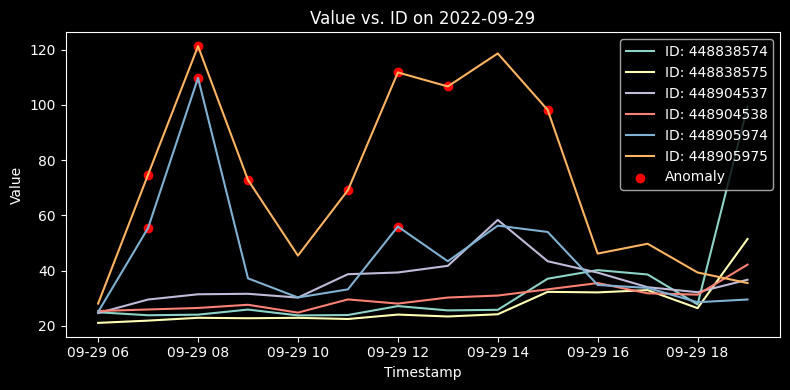

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the data for the specific date
date = pd.Timestamp('2022-09-29')
filtered_df = result[result['timestamp'].dt.date == date.date()]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot value for each id
for id in filtered_df['id'].unique():
    data = filtered_df[filtered_df['id'] == id]
    ax.plot(data['timestamp'], data['value'], label=f"ID: {id}")

# Add red scatter points for anomaly
anomaly_data = filtered_df[filtered_df['anomaly']]
ax.scatter(anomaly_data['timestamp'], anomaly_data['value'], color='red', label='Anomaly')

# Set the title and labels
ax.set_title(f"Value vs. ID on {date.date()}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Value")

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()